## **Inference Code of Low-Resource ASR for Nasal Language [1]**

submitted by Ravialdy Hidayat.

Paper Reference: [1] Bartelds et al., "Making More of Little Data: Improving Low-Resource Automatic Speech Recognition Using Data Augmentation" in Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (ACL), July 2023

### Brief Recap about Low-Resource Nasal language

Nasal is still used by local people from several villages in Tanjung Betuah, Gedung Menung, and Tanjung Baru within Kaur Regency, Bengkulu Province, Sumatra, Indonesia [2].

Paper Reference: [2] Smith et al., "The Western Malayo-Polynesian Problem" in Proceedings of the 31st Annual Meeting of the Southeast Asian Linguistics Society (SEALS 31), May 2022.

### Explanation of the Model

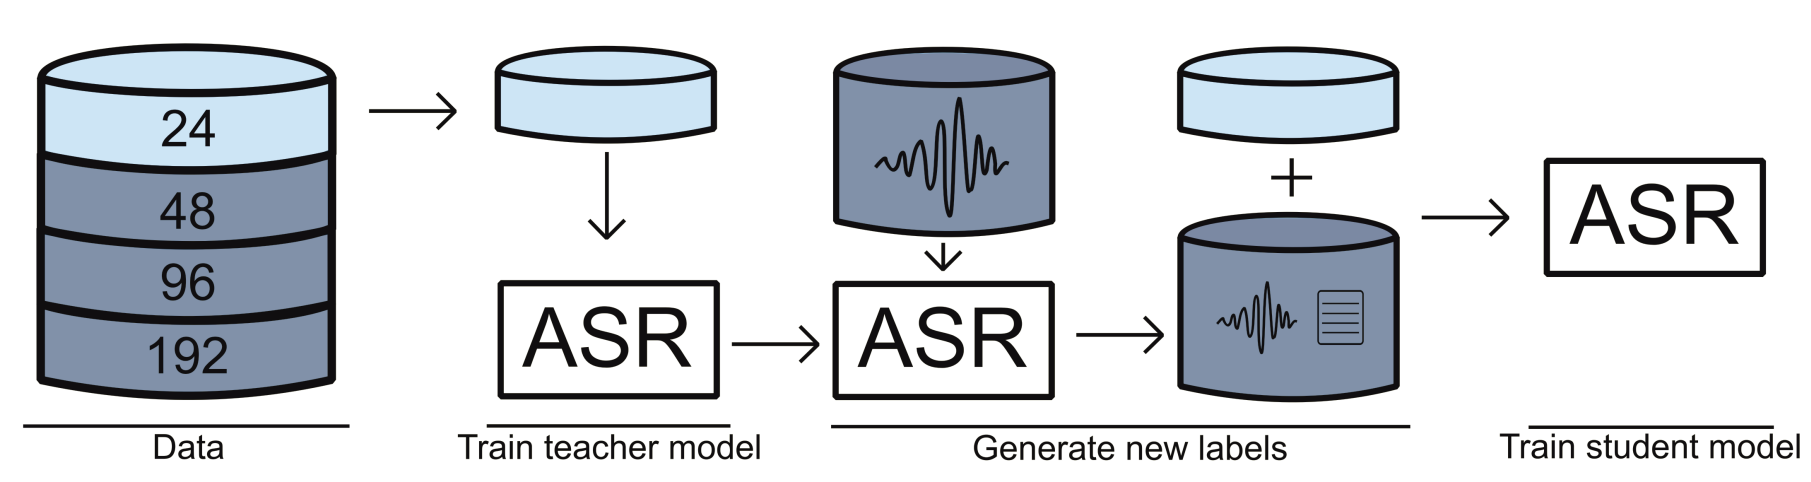

As you can see from the figure above, the teacher model in [1] is initially trained from a very small subset of data that is manually annotated by human (24 minutes of spoken audio). After that, the teacher model will be used to generate pseudo-labels for the remaining unlabeled data. Then, it will be merged with the labeled one to get the total dataset to train student model.

Note that as explained in [1], for both pre-training and fine-tuning process the authors of that paper use XLS-R model by [3].

Paper reference : [3] Babu et al., "XLS-R: Self-supervised Cross-lingual Speech Representation Learning at Scale.", Conference of the International Speech Communication Association (Interspeech), 2022.

### Install and import necessary libraries

In [ ]:
!pip install transformers torchaudio jiwer datasets
from typing import Optional, Tuple, Dict, List
import torchaudio
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import soundfile as sf
import jiwer
import time

### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define function to load ASR model

In [ ]:
def load_model_asr(model_key, device):

    processor = Wav2Vec2Processor.from_pretrained(model_key)

    model = Wav2Vec2ForCTC.from_pretrained(model_key)
    model = model.to(device).eval()

    return model, processor

### Define function to read the audio file

In [ ]:
def read_audio_colab(file_path):
    audio_input, sampling_rate = sf.read(file_path)
    assert sampling_rate == 16_000, "Must use sampling rate 16,000 Hz [1]"
    return audio_input

def read_audio_drive(name_file: str, name_folder: str):
    full_path = '/content/drive/MyDrive/' + name_folder + '/' + name_file
    try:
        audio_input, sampling_rate = sf.read(full_path)
        assert sampling_rate == 16_000, "Must use sampling rate 16,000 Hz [1]"
        return audio_input
    except FileNotFoundError:
        print(f"The file {full_path} is not found in Google Drive.")
        return None

### Define function to perform inference

In [ ]:
def transcribe_inference(audio_input, model, processor, device):
    inputs = processor(audio_input, sampling_rate=16_000, return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model(inputs.input_values.to(device), attention_mask=inputs.attention_mask.to(device)).logits

    pred_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(pred_ids)
    return transcription[0]

### Load the Models used for benchmarking

In [ ]:
model_id_ori = "bartelds/nasal-gpu6-cp0_adp0_48m_5e-5_cp-13000"
model_id_aug = "bartelds/nasal-gpu6-cp0_adp0_96m-silver_96-orig_5e-4_cp-13000"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ori, processor_ori = load_model_asr(model_id_ori, device)
model_aug, processor_aug = load_model_asr(model_id_aug, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at bartelds/nasal-gpu6-cp0_adp0_48m_5e-5_cp-13000 were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT 

### Inference results

In [ ]:
drive_file = ""
folder_drive = ""
file_path = "/content/BJM02-001-01_S1-A_00h21m56.526.wav"

# Check and process the audio input (from colab or drive)
if file_path != "":
    audio_input = read_audio_colab(file_path)
elif drive_file != "":
    audio_input = read_audio_drive(drive_file, folder_drive)
else:
    audio_input = None
    print("Warning: Please input a correct path for the audio input.")

# Generate transcription result if audio input is available
if audio_input is not None:
    transcription_ori = transcribe_inference(audio_input, model_ori, processor_ori, device)
    transcription_aug = transcribe_inference(audio_input, model_aug, processor_aug, device)
    print(f"Transcribed text generated by Proposed Model without data augmentation: ", transcription_ori)
    print(f"Transcribed text generated by Proposed Model with data augmentation: ",transcription_aug)
else:
    print("No audio data for transcription. Please check the path of your audio input again!")

Transcribed text generated by Proposed Model without data augmentation:  mayatyo gawuh masinyo di bahun kan
Transcribed text generated by Proposed Model with data augmentation:  mayatnyo gawuh masih di bahun kan


## **Performance of Low-Resource ASR for Nasal Language [1]**

submitted by Ravialdy Hidayat.

Paper Reference: [1] Bartelds et al., "Making More of Little Data: Improving Low-Resource Automatic Speech Recognition Using Data Augmentation" in Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (ACL), July 2023

### Define the metrics

I define two evaluation metrics to analyze the performance of ASR models used in this simulation. The first one is Word Error Rate (WER) and the second one is Character Error Rate (CER). Both of them have similar formula as follows :

$$ \frac{S + D + I}{N} $$

\begin{align*}
\text{Notations:} \quad & \\
S & \text{: Number of substitutions.} \\
D & \text{: Number of deletions.} \\
I & \text{: Number of insertions.} \\
N & \text{: Number of words (WER) or characters (CER) in the reference.} \\
\end{align*}

### Define the test dataset

For the best of my knowledge, the only dataset available online for low-resource Nasal language is the one provided by [1]. Thus, I decided to use the test dataset from that paper.

### Load the test dataset

In [ ]:
import pandas as pd
from datasets import Dataset

testset_path = "/content/drive/MyDrive/nasal language/test.tsv"
test_ds = pd.read_csv(testset_path, sep='\t')
name_folder = 'nasal language'

test_ds['audio'] = [read_audio_drive(path, name_folder) for path in test_ds['path'].tolist()]
test_ds = Dataset.from_pandas(test_ds[['audio', 'text']])

### Define function to test entire dataset

In [ ]:
def test_dataset(dataset, model, processor, device, batch_size):
    total_time = 0

    def evaluate_batch(batch):
        nonlocal total_time
        start_time = time.time()
        dict_batch = {}
        inputs = processor(batch["audio"], sampling_rate=16_000, return_tensors="pt", padding=True)

        with torch.no_grad():
            logits = model(inputs.input_values.to(device), attention_mask=inputs.attention_mask.to(device)).logits
        pred_ids = torch.argmax(logits, dim=-1)
        transcriptions = processor.batch_decode(pred_ids)
        batch_time = time.time() - start_time
        total_time += batch_time

        dict_batch["batch_texts"] = batch["text"]
        dict_batch["out_transcript"] = transcriptions

        return dict_batch

    results = dataset.map(evaluate_batch, batched=True, batch_size=batch_size)
    wer_score = round(jiwer.wer(results["batch_texts"], results["out_transcript"]), 2)
    cer_score = round(jiwer.cer(results["batch_texts"], results["out_transcript"]), 2)

    return {
        "wer": wer_score,
        "cer": cer_score,
        "total_time": total_time
    }

### Perform evaluation for both ASR models

In [ ]:
evaluation_results_ori = test_dataset(test_ds, model_ori, processor_ori, device, batch_size=8)
evaluation_results_aug = test_dataset(test_ds, model_aug, processor_aug, device, batch_size=8)

print("Evaluation results for the proposed model without augmented data:")
print(f"WER: {evaluation_results_ori['wer']}, CER: {evaluation_results_ori['cer']}, Total Time: {evaluation_results_ori['total_time']} seconds")

print("\nEvaluation results for the proposed model with augmented data:")
print(f"WER: {evaluation_results_aug['wer']}, CER: {evaluation_results_aug['cer']}, Total Time: {evaluation_results_aug['total_time']} seconds")

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Evaluation results for the proposed model without augmented data:
WER: 0.51, CER: 0.18, Total Time: 35.203206062316895 seconds

Evaluation results for the proposed model with augmented data:
WER: 0.44, CER: 0.15, Total Time: 33.507813453674316 seconds


### Results Analysis

As you can see from the evaluation done before, the model with augmentation data performs better than the one without it for both Word Error Rate (WER) and Character Error Rate (CER) metrics. This means that data augmentation with self-training method as proposed in [1] does indeed perform better than without data augmentation at all.